<a href="https://colab.research.google.com/github/sujitojha1/ERA1/blob/main/Session7/ERA1_S7_step2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
%load_ext autoreload
%autoreload 2

## Loading Models

In [ ]:
!pip install torchsummary
!git clone https://github.com/sujitojha1/ERA1 -q --quiet
!mv ERA1/Session7/*.py .
!rm -rf ERA1

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


## Step 2
### Target
1. Add image augmentation w random rotation and random affine to improve the model performance.


In [ ]:
from __future__ import print_function
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms

## Data Transformations


In [ ]:
# Train Phase transformations
train_transforms = transforms.Compose([
                                       transforms.RandomRotation((-15.0, 15.0), fill=(1,)),
                                       transforms.ToTensor(),
                                       transforms.Normalize((0.1307,), (0.3081,)) # The mean and std have to be sequences (e.g., tuples), therefore you should add a comma after the values.
                                       # Note the difference between (0.1307) and (0.1307,)
                                       ])

# Test Phase transformations
test_transforms = transforms.Compose([
                                       transforms.ToTensor(),
                                       transforms.Normalize((0.1307,), (0.3081,))
                                       ])

In [ ]:
train = datasets.MNIST('./data', train=True, download = True, transform=train_transforms)
test = datasets.MNIST('./data', train=False, download=True, transform=test_transforms)

100%|██████████| 9912422/9912422 [00:00<00:00, 356842427.64it/s]

Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw


100%|██████████| 28881/28881 [00:00<00:00, 102919026.19it/s]


Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw



100%|██████████| 1648877/1648877 [00:00<00:00, 124223436.79it/s]


Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw



100%|██████████| 4542/4542 [00:00<00:00, 3866557.49it/s]


Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw



## Dataloader Arguments & Test/Train Dataloaders

In [ ]:
SEED = 1

# CUDA?
cuda = torch.cuda.is_available()
print("CUDA Availalbe?", cuda)

# For reproducibility
torch.manual_seed(SEED)

if cuda:
    torch.cuda.manual_seed(SEED)

# dataloader arguments
dataloader_args = dict(shuffle=True,batch_size=128,num_workers=4,pin_memory=True) if cuda else dict(shuffle=True, batch_size=64)

# train dataloader
train_loader = torch.utils.data.DataLoader(train, **dataloader_args)

# test dataloader
test_loader = torch.utils.data.DataLoader(test, **dataloader_args)

CUDA Availalbe? True


/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:560: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


## Model

In [ ]:
from model import *
Net = Model_2

## Model Params

In [ ]:
!pip install torchsummary
from torchsummary import summary
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
print(device)
model = Net().to(device)
summary(model, input_size=(1, 28, 28))

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
cuda
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1            [-1, 8, 26, 26]              72
              ReLU-2            [-1, 8, 26, 26]               0
       BatchNorm2d-3            [-1, 8, 26, 26]              16
           Dropout-4            [-1, 8, 26, 26]               0
            Conv2d-5           [-1, 16, 24, 24]           1,152
              ReLU-6           [-1, 16, 24, 24]               0
       BatchNorm2d-7           [-1, 16, 24, 24]              32
           Dropout-8           [-1, 16, 24, 24]               0
            Conv2d-9            [-1, 8, 24, 24]             128
        MaxPool2d-10            [-1, 8, 12, 12]               0
           Conv2d-11           [-1, 16, 10, 10]           1,152
             ReLU-12           [-1, 16, 10, 10]               0

## Training and Testing

In [ ]:
from tqdm import tqdm

train_losses = []
test_losses = []
train_acc = []
test_acc = []

def train(model, device, train_loader, optimizer, epoch):
  model.train()
  pbar = tqdm(train_loader)
  correct = 0
  processed = 0
  for batch_idx, (data, target) in enumerate(pbar):
    # get samples
    data, target = data.to(device), target.to(device)

    # Init
    optimizer.zero_grad()
    # In PyTorch, we need to set the gradients to zero before starting to do backpropragation because PyTorch accumulates the gradients on subsequent backward passes.
    # Because of this, when you start your training loop, ideally you should zero out the gradients so that you do the parameter update correctly.

    # Predict
    y_pred = model(data)

    # Calculate loss
    loss = F.nll_loss(y_pred, target)
    train_losses.append(loss.item())

    # Backpropagation
    loss.backward()
    optimizer.step()

    # Update pbar-tqdm

    pred = y_pred.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
    correct += pred.eq(target.view_as(pred)).sum().item()
    processed += len(data)

    pbar.set_description(desc= f'Loss={loss.item()} Batch_id={batch_idx} Accuracy={100*correct/processed:0.2f}')
    train_acc.append(100*correct/processed)

def test(model, device, test_loader):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += F.nll_loss(output, target, reduction='sum').item()  # sum up batch loss
            pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(test_loader.dataset)
    test_losses.append(test_loss)

    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.2f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))

    test_acc.append(100. * correct / len(test_loader.dataset))

In [ ]:
model =  Net().to(device)
optimizer = optim.SGD(model.parameters(), lr=0.05, momentum=0.9)


EPOCHS = 15
for epoch in range(EPOCHS):
    print("EPOCH:", epoch)
    train(model, device, train_loader, optimizer, epoch)
    test(model, device, test_loader)

EPOCH: 0


Loss=0.20879359543323517 Batch_id=468 Accuracy=92.54: 100%|██████████| 469/469 [00:26<00:00, 17.78it/s]



Test set: Average loss: 0.0698, Accuracy: 9778/10000 (97.78%)

EPOCH: 1


Loss=0.09381597489118576 Batch_id=468 Accuracy=96.83: 100%|██████████| 469/469 [00:21<00:00, 22.08it/s]



Test set: Average loss: 0.0589, Accuracy: 9809/10000 (98.09%)

EPOCH: 2


Loss=0.0767873078584671 Batch_id=468 Accuracy=97.35: 100%|██████████| 469/469 [00:21<00:00, 21.47it/s]



Test set: Average loss: 0.0449, Accuracy: 9845/10000 (98.45%)

EPOCH: 3


Loss=0.006903907284140587 Batch_id=468 Accuracy=97.61: 100%|██████████| 469/469 [00:22<00:00, 21.02it/s]



Test set: Average loss: 0.0356, Accuracy: 9871/10000 (98.71%)

EPOCH: 4


Loss=0.05889439955353737 Batch_id=468 Accuracy=97.89: 100%|██████████| 469/469 [00:22<00:00, 20.88it/s]



Test set: Average loss: 0.0361, Accuracy: 9885/10000 (98.85%)

EPOCH: 5


Loss=0.04528383910655975 Batch_id=468 Accuracy=97.89: 100%|██████████| 469/469 [00:24<00:00, 18.98it/s]



Test set: Average loss: 0.0310, Accuracy: 9903/10000 (99.03%)

EPOCH: 6


Loss=0.03618514537811279 Batch_id=468 Accuracy=97.90: 100%|██████████| 469/469 [00:23<00:00, 19.90it/s]



Test set: Average loss: 0.0283, Accuracy: 9912/10000 (99.12%)

EPOCH: 7


Loss=0.1429448276758194 Batch_id=468 Accuracy=98.05: 100%|██████████| 469/469 [00:22<00:00, 20.62it/s]



Test set: Average loss: 0.0292, Accuracy: 9909/10000 (99.09%)

EPOCH: 8


Loss=0.029138023033738136 Batch_id=468 Accuracy=98.06: 100%|██████████| 469/469 [00:23<00:00, 20.20it/s]



Test set: Average loss: 0.0274, Accuracy: 9909/10000 (99.09%)

EPOCH: 9


Loss=0.017573120072484016 Batch_id=468 Accuracy=98.09: 100%|██████████| 469/469 [00:21<00:00, 21.44it/s]



Test set: Average loss: 0.0307, Accuracy: 9903/10000 (99.03%)

EPOCH: 10


Loss=0.08157876878976822 Batch_id=468 Accuracy=98.31: 100%|██████████| 469/469 [00:21<00:00, 22.00it/s]



Test set: Average loss: 0.0258, Accuracy: 9919/10000 (99.19%)

EPOCH: 11


Loss=0.03797043487429619 Batch_id=468 Accuracy=98.20: 100%|██████████| 469/469 [00:21<00:00, 21.89it/s]



Test set: Average loss: 0.0308, Accuracy: 9905/10000 (99.05%)

EPOCH: 12


Loss=0.05655645951628685 Batch_id=468 Accuracy=98.28: 100%|██████████| 469/469 [00:23<00:00, 19.94it/s]



Test set: Average loss: 0.0281, Accuracy: 9912/10000 (99.12%)

EPOCH: 13


Loss=0.03389120474457741 Batch_id=468 Accuracy=98.37: 100%|██████████| 469/469 [00:22<00:00, 20.69it/s]



Test set: Average loss: 0.0302, Accuracy: 9902/10000 (99.02%)

EPOCH: 14


Loss=0.01105316262692213 Batch_id=468 Accuracy=98.34: 100%|██████████| 469/469 [00:22<00:00, 20.90it/s]



Test set: Average loss: 0.0256, Accuracy: 9914/10000 (99.14%)



Text(0.5, 1.0, 'Test Accuracy')

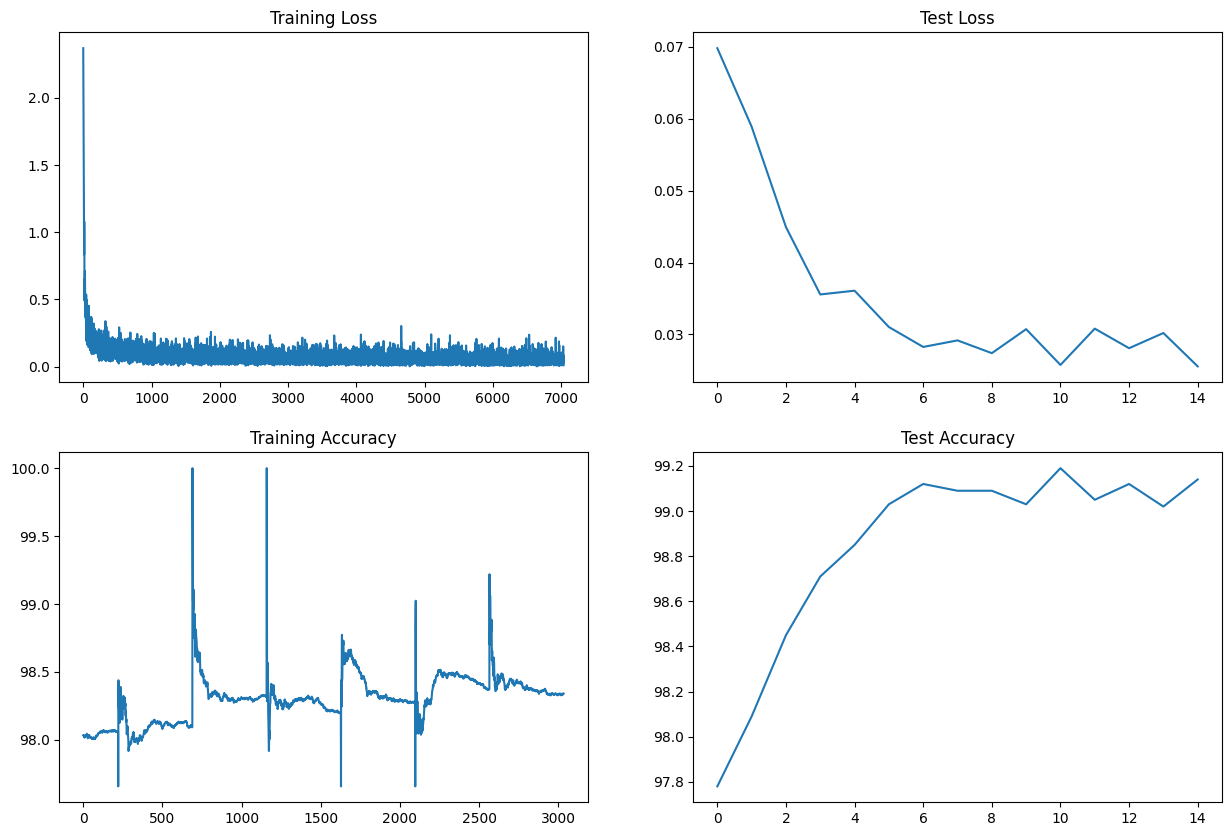

In [ ]:
%matplotlib inline
import matplotlib.pyplot as plt

fig, axs = plt.subplots(2,2,figsize=(15,10))
axs[0, 0].plot(train_losses)
axs[0, 0].set_title("Training Loss")
axs[1, 0].plot(train_acc[4000:])
axs[1, 0].set_title("Training Accuracy")
axs[0, 1].plot(test_losses)
axs[0, 1].set_title("Test Loss")
axs[1, 1].plot(test_acc)
axs[1, 1].set_title("Test Accuracy")